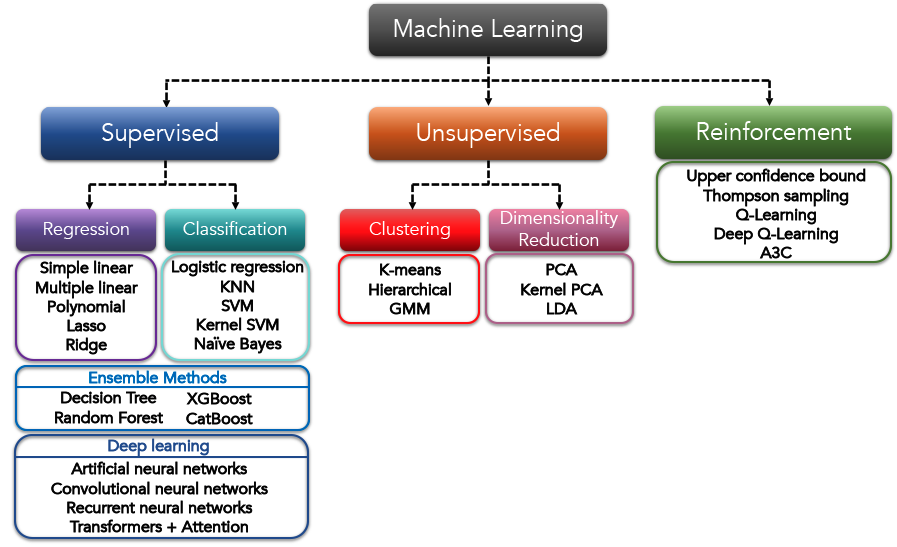

# Required Things;

In [1]:
import os

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [3]:
import warnings
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")
np.random.seed(1234)

In [4]:
import datetime
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer

# Data Reads for Tabular Data;

In [5]:
df=pd.read_csv("/kaggle/input/customer-personality-analysis/marketing_campaign.csv", sep="\t")

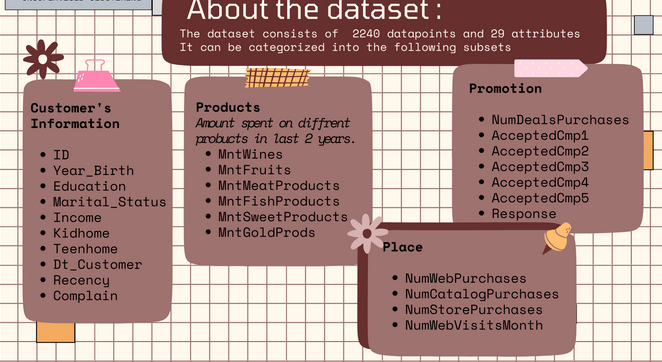

In [6]:
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


In [7]:
df.shape

(2240, 29)

In [8]:
#Information on features 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

In [9]:
#To remove the NA values
df= df.dropna()
print("The total number of data-points after removing the rows with missing values are:", len(df))

The total number of data-points after removing the rows with missing values are: 2216


**Data Engineering or Feature Engineering, Data Cleaning**

In the next step, I am going to create a feature out of "Dt_Customer" that indicates the number of days a customer is registered in the firm's database. However, in order to keep it simple, I am taking this value relative to the most recent customer in the record.

Thus to get the values I must check the newest and oldest recorded dates.


In [10]:
df["Dt_Customer"] = pd.to_datetime(df["Dt_Customer"])
dates = []
for i in df["Dt_Customer"]:
    i = i.date()
    dates.append(i)  
#Dates of the newest and oldest recorded customer
print("The newest customer's enrolment date in therecords:",max(dates))
print("The oldest customer's enrolment date in the records:",min(dates))

The newest customer's enrolment date in therecords: 2014-12-06
The oldest customer's enrolment date in the records: 2012-01-08


Creating a feature ("Customer_For") of the number of days the customers started to shop in the store relative to the last recorded date

In [11]:
#Created a feature "Customer_For"
days = []
d1 = max(dates) #taking it to be the newest customer
for i in dates:
    delta = d1 - i
    days.append(delta)
df["Customer_For"] = days
df["Customer_For"] = pd.to_numeric(df["Customer_For"], errors="coerce")

Now we will be exploring the unique values in the categorical features to get a clear idea of the data.

In [12]:
print("Total categories in the feature Marital_Status:\n", df["Marital_Status"].value_counts(), "\n")

Total categories in the feature Marital_Status:
 Married     857
Together    573
Single      471
Divorced    232
Widow        76
Alone         3
Absurd        2
YOLO          2
Name: Marital_Status, dtype: int64 



In [13]:
print("Total categories in the feature Education:\n", df["Education"].value_counts())

Total categories in the feature Education:
 Graduation    1116
PhD            481
Master         365
2n Cycle       200
Basic           54
Name: Education, dtype: int64




In the next bit, I will be performing the following steps to engineer some new features:

*    Extract the "Age" of a customer by the "Year_Birth" indicating the birth year of    the respective person.
   
*    Create another feature "Spent" indicating the total amount spent by the      customer in various categories over the span of two years.
    
*    Create another feature "Living_With" out of "Marital_Status" to extract the living situation of couples.
    
*    Create a feature "Children" to indicate total children in a household that is, kids and teenagers.
   
*    To get further clarity of household, Creating feature indicating "Family_Size"
*     Create a feature "Is_Parent" to indicate parenthood status
    Lastly, I will create three categories in the "Education" by simplifying its value counts.
    
   Dropping some of the redundant features



In [14]:
#Feature Engineering

#Age of customer today 
df["Age"] = 2023-df["Year_Birth"]

#Total spendings on various items
df["Spent"] = df["MntWines"]+ df["MntFruits"]+ df["MntMeatProducts"]+ df["MntFishProducts"]+ df["MntSweetProducts"]+ df["MntGoldProds"]

#Deriving living situation by marital status"Alone"
df["Living_With"]=df["Marital_Status"].replace({"Married":"Partner", "Together":"Partner", "Absurd":"Alone", "Widow":"Alone", "YOLO":"Alone", "Divorced":"Alone", "Single":"Alone",})

#Feature indicating total children living in the household
df["Children"]=df["Kidhome"]+df["Teenhome"]

#Feature for total members in the householde
df["Family_Size"] = df["Living_With"].replace({"Alone": 1, "Partner":2})+ df["Children"]

#Feature pertaining parenthood
df["Is_Parent"] = np.where(df.Children> 0, 1, 0)

#Segmenting education levels in three groups
df["Education"]=df["Education"].replace({"Basic":"Undergraduate","2n Cycle":"Undergraduate", "Graduation":"Graduate", "Master":"Postgraduate", "PhD":"Postgraduate"})

#For clarity
df=df.rename(columns={"MntWines": "Wines","MntFruits":"Fruits","MntMeatProducts":"Meat","MntFishProducts":"Fish","MntSweetProducts":"Sweets","MntGoldProds":"Gold"})

#Dropping some of the redundant features
to_drop = ["Marital_Status", "Dt_Customer", "Z_CostContact", "Z_Revenue", "Year_Birth", "ID"]
df = df.drop(to_drop, axis=1)

In [15]:
df.head(10)

,Education,Income,Kidhome,Teenhome,Recency,Wines,Fruits,Meat,Fish,Sweets,...,AcceptedCmp2,Complain,Response,Customer_For,Age,Spent,Living_With,Children,Family_Size,Is_Parent
0,Graduate,58138.0,0,0,58,635,88,546,172,88,...,0,0,1,83894400000000000,66,1617,Alone,0,1,0
1,Graduate,46344.0,1,1,38,11,1,6,2,1,...,0,0,0,10800000000000000,69,27,Alone,2,3,1
2,Graduate,71613.0,0,0,26,426,49,127,111,21,...,0,0,0,40780800000000000,58,776,Partner,0,2,0
3,Graduate,26646.0,1,0,26,11,4,20,10,3,...,0,0,0,5616000000000000,39,53,Partner,1,3,1
4,Postgraduate,58293.0,1,0,94,173,43,118,46,27,...,0,0,0,27734400000000000,42,422,Partner,1,3,1
5,Postgraduate,62513.0,0,1,16,520,42,98,0,42,...,0,0,0,39139200000000000,56,716,Partner,1,3,1
6,Graduate,55635.0,0,1,34,235,65,164,50,49,...,0,0,0,65059200000000000,52,590,Alone,1,2,1
7,Postgraduate,33454.0,1,0,32,76,10,56,3,1,...,0,0,0,42163200000000000,38,169,Partner,1,3,1
8,Postgraduate,30351.0,1,0,19,14,0,24,3,3,...,0,0,1,47347200000000000,49,46,Partner,1,3,1
9,Postgraduate,5648.0,1,1,68,28,0,6,1,1,...,0,0,0,23155200000000000,73,49,Partner,2,4,1


In [16]:
df.describe()

,Income,Kidhome,Teenhome,Recency,Wines,Fruits,Meat,Fish,Sweets,Gold,...,AcceptedCmp1,AcceptedCmp2,Complain,Response,Customer_For,Age,Spent,Children,Family_Size,Is_Parent
count,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,...,2216.000000,2216.000000,2216.000000,2216.000000,2.216000e+03,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000
mean,52247.251354,0.441787,0.505415,49.012635,305.091606,26.356047,166.995939,37.637635,27.028881,43.965253,...,0.064079,0.013538,0.009477,0.150271,4.423735e+16,54.179603,607.075361,0.947202,2.592509,0.714350
std,25173.076661,0.536896,0.544181,28.948352,337.327920,39.793917,224.283273,54.752082,41.072046,51.815414,...,0.244950,0.115588,0.096907,0.357417,2.008532e+16,11.985554,602.900476,0.749062,0.905722,0.451825
min,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000e+00,27.000000,5.000000,0.000000,1.000000,0.000000
25%,35303.000000,0.000000,0.000000,24.000000,24.000000,2.000000,16.000000,3.000000,1.000000,9.000000,...,0.000000,0.000000,0.000000,0.000000,2.937600e+16,46.000000,69.000000,0.000000,2.000000,0.000000
50%,51381.500000,0.000000,0.000000,49.000000,174.500000,8.000000,68.000000,12.000000,8.000000,24.500000,...,0.000000,0.000000,0.000000,0.000000,4.432320e+16,53.000000,396.500000,1.000000,3.000000,1.000000
75%,68522.000000,1.000000,1.000000,74.000000,505.000000,33.000000,232.250000,50.000000,33.000000,56.000000,...,0.000000,0.000000,0.000000,0.000000,5.927040e+16,64.000000,1048.000000,1.000000,3.000000,1.000000
max,666666.000000,2.000000,2.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,262.000000,321.000000,...,1.000000,1.000000,1.000000,1.000000,9.184320e+16,130.000000,2525.000000,3.000000,5.000000,1.000000


Reletive Plot Of Some Selected Features: A Data Subset


<Figure size 800x550 with 0 Axes>

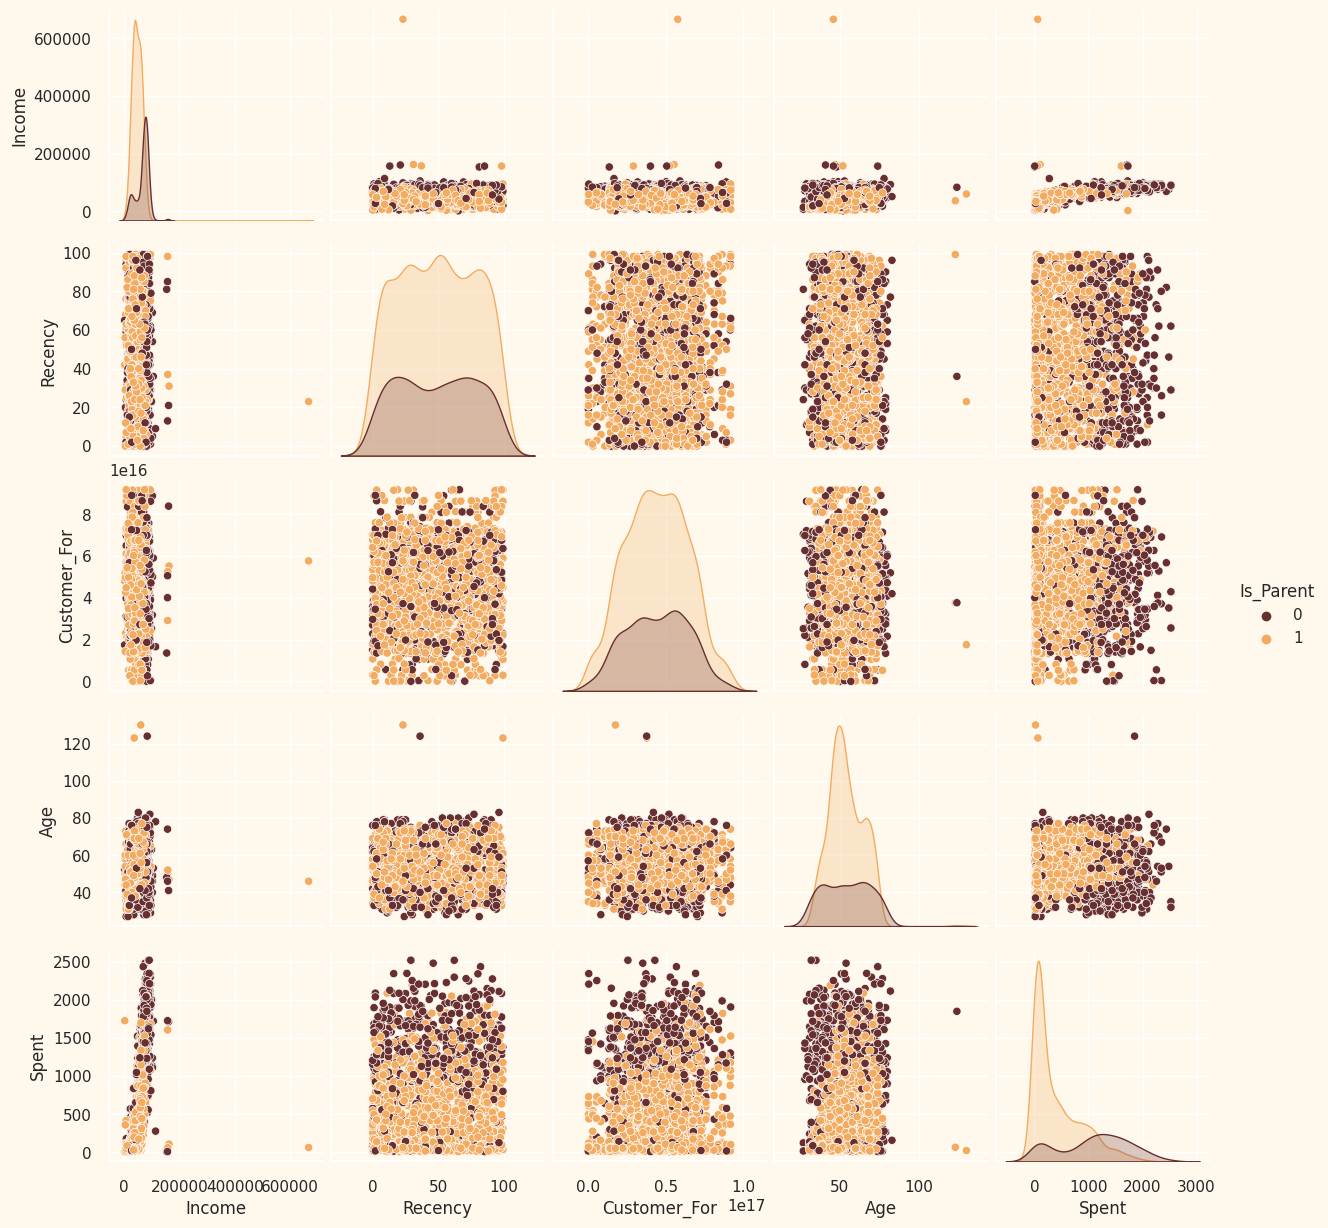

In [17]:
#To plot some selected features 

#Setting up colors prefrences
sns.set(rc={"axes.facecolor":"#FFF9ED","figure.facecolor":"#FFF9ED"})

pallet = ["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"]
cmap = colors.ListedColormap(["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"])

#Plotting following features
To_Plot = [ "Income", "Recency", "Customer_For", "Age", "Spent", "Is_Parent"]
print("Reletive Plot Of Some Selected Features: A Data Subset")

plt.figure()
sns.pairplot(df[To_Plot], hue= "Is_Parent",palette= (["#682F2F","#F3AB60"]))
#Taking hue 
plt.show()

In [18]:
#Dropping the outliers by setting a cap on Age and income. 
df = df[(df["Age"]<90)]
df = df[(df["Income"]<600000)]
print("The total number of data-points after removing the outliers are:", len(df))

The total number of data-points after removing the outliers are: 2212


<AxesSubplot: >

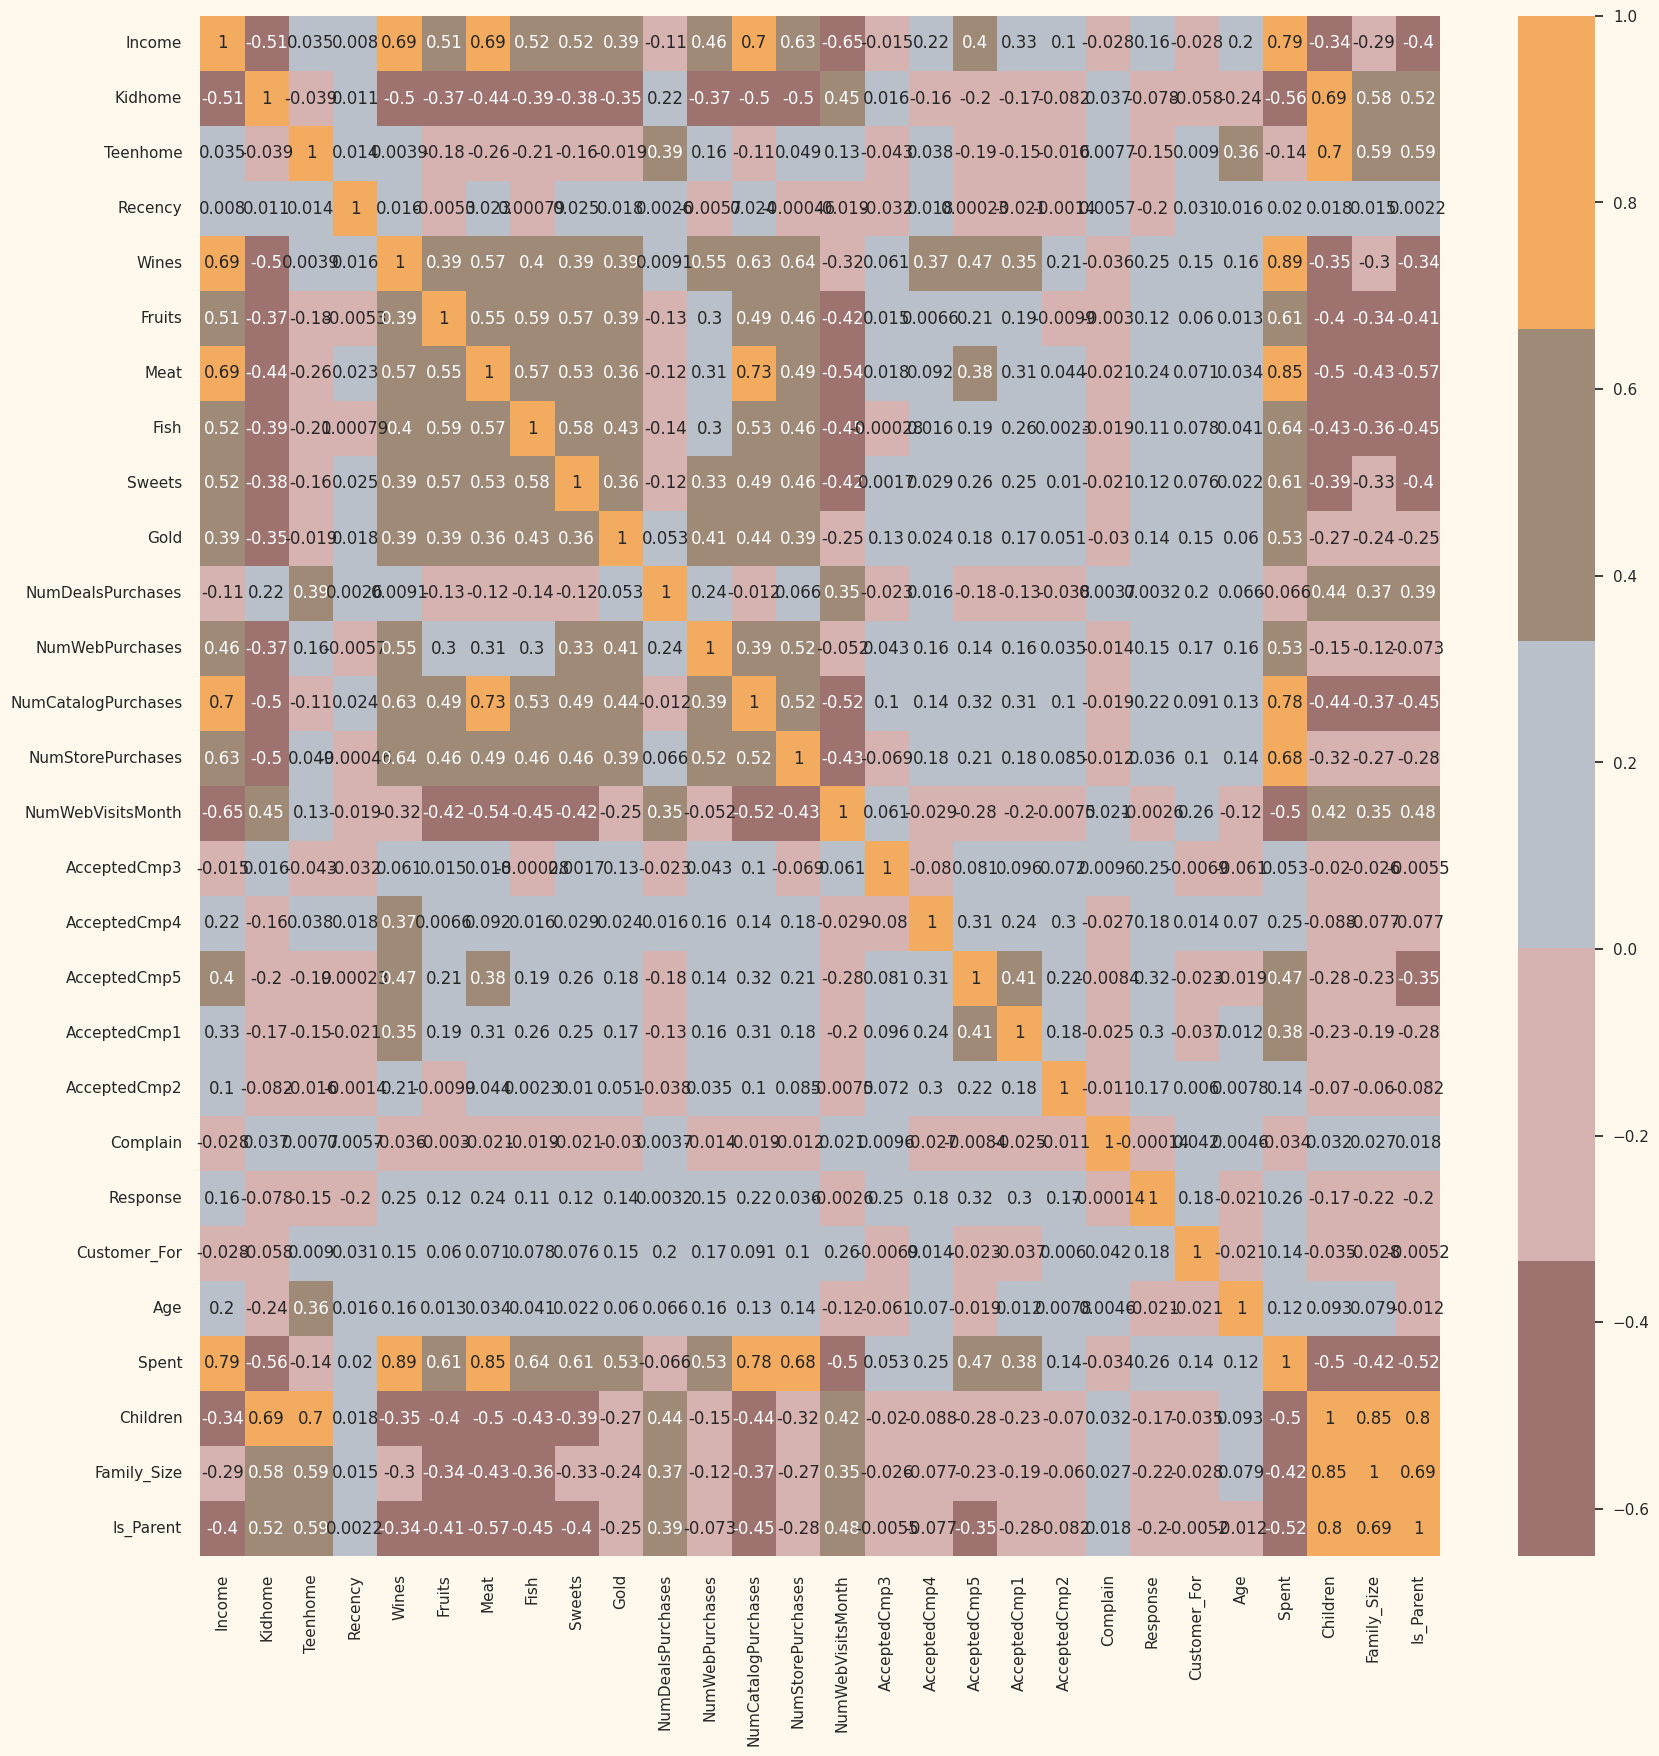

In [19]:
#correlation matrix
corrmat= df.corr()
plt.figure(figsize=(20,20))  
sns.heatmap(corrmat,annot=True, cmap=cmap, center=0)

In [20]:
#Get list of categorical variables
k = (df.dtypes == 'object')
object_cols = list(k[k].index)

print("Categorical variables in the dataset:", object_cols)

Categorical variables in the dataset: ['Education', 'Living_With']


In [21]:
#Label Encoding the object dtypes.
LE=LabelEncoder()
for i in object_cols:
    df[i]=df[[i]].apply(LE.fit_transform)
    
print("All features are now numerical")

All features are now numerical


In [22]:
ds = df.copy()
# creating a subset of dataframe by dropping the features on deals accepted and promotions
cols_del = ['AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1','AcceptedCmp2', 'Complain', 'Response']
ds = ds.drop(cols_del, axis=1)

#Scaling
scaler = StandardScaler()
scaler.fit(ds)

scaled_ds = pd.DataFrame(scaler.transform(ds),columns= ds.columns )
print("All features are now scaled")

All features are now scaled


**DIMENSIONALITY REDUCTION;**

Principal component analysis (PCA) is a technique for reducing the dimensionality of such datasets, increasing interpretability but at the same time minimizing information loss.

Steps in this section:

1.    Dimensionality reduction with PCA
1.    Plotting the reduced dataframe

**Dimensionality reduction with PCA**

For this project, I will be reducing the dimensions to 3.

In [23]:
#Initiating PCA to reduce dimentions aka features to 3
pca = PCA(n_components=3)
pca.fit(scaled_ds)
PCA_ds = pd.DataFrame(pca.transform(scaled_ds), columns=(["col1","col2", "col3"]))
PCA_ds.describe().T

,count,mean,std,min,25%,50%,75%,max
col1,2212.0,1.927331e-17,2.878377,-5.969394,-2.538494,-0.780421,2.383290,7.444305
col2,2212.0,1.927331e-17,1.706839,-4.312173,-1.328334,-0.158265,1.242258,6.142826
col3,2212.0,2.971302e-17,1.221950,-3.525717,-0.828670,-0.020929,0.800374,6.611154


In [24]:
PCA_ds.describe()

,col1,col2,col3
count,2.212000e+03,2.212000e+03,2.212000e+03
mean,1.927331e-17,1.927331e-17,2.971302e-17
std,2.878377e+00,1.706839e+00,1.221950e+00
min,-5.969394e+00,-4.312173e+00,-3.525717e+00
25%,-2.538494e+00,-1.328334e+00,-8.286696e-01
50%,-7.804210e-01,-1.582649e-01,-2.092880e-02
75%,2.383290e+00,1.242258e+00,8.003741e-01
max,7.444305e+00,6.142826e+00,6.611154e+00


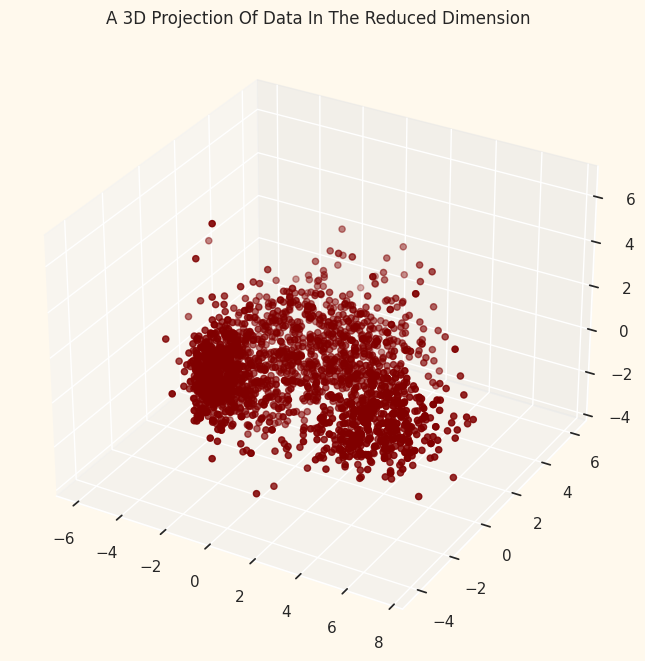

In [25]:
#A 3D Projection Of Data In The Reduced Dimension
x =PCA_ds["col1"]
y =PCA_ds["col2"]
z =PCA_ds["col3"]

#To plot
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(x,y,z, c="maroon", marker="o" )
ax.set_title("A 3D Projection Of Data In The Reduced Dimension")

plt.show()

**Unsupervised Machine Learning**

Now that I have reduced the attributes to three dimensions, I will be performing clustering via Agglomerative clustering. Agglomerative clustering is a hierarchical clustering method. It involves merging examples until the desired number of clusters is achieved.

Steps involved in the Clustering

*    Elbow Method to determine the number of clusters to be formed
*    Clustering via Agglomerative Clustering
*    Examining the clusters formed via scatter plot


Elbow Method to determine the number of clusters to be formed:


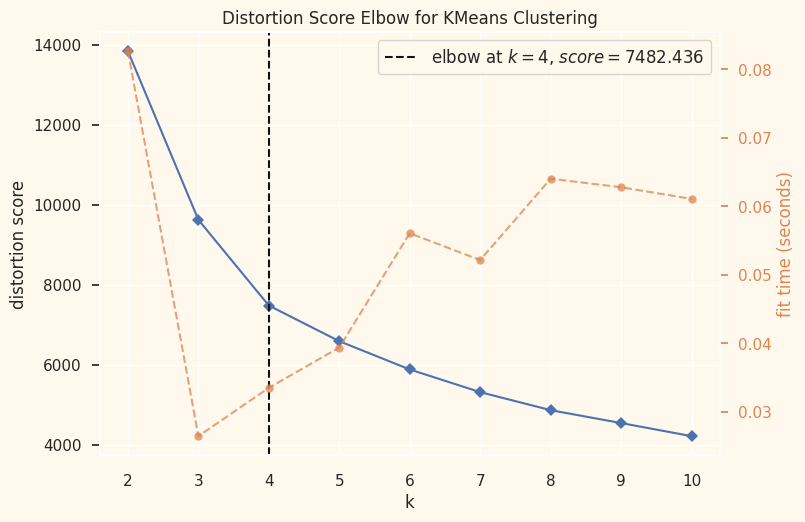

<AxesSubplot: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [26]:
# Quick examination of elbow method to find numbers of clusters to make.
print('Elbow Method to determine the number of clusters to be formed:')
Elbow_M = KElbowVisualizer(KMeans(), k=10)
Elbow_M.fit(PCA_ds)

Elbow_M.show()

The above cell indicates that *four* will be an optimal number of clusters for this data. Next, we will be fitting the Agglomerative Clustering Model to get the final clusters.

In [27]:
#Initiating the Agglomerative Clustering model 
AC = AgglomerativeClustering(n_clusters=4)

# fit model and predict clusters
yhat_AC = AC.fit_predict(PCA_ds)
PCA_ds["Clusters"] = yhat_AC

#Adding the Clusters feature to the orignal dataframe.
df["Clusters"]= yhat_AC

To examine the clusters formed let's have a look at the 3-D distribution of the clusters.

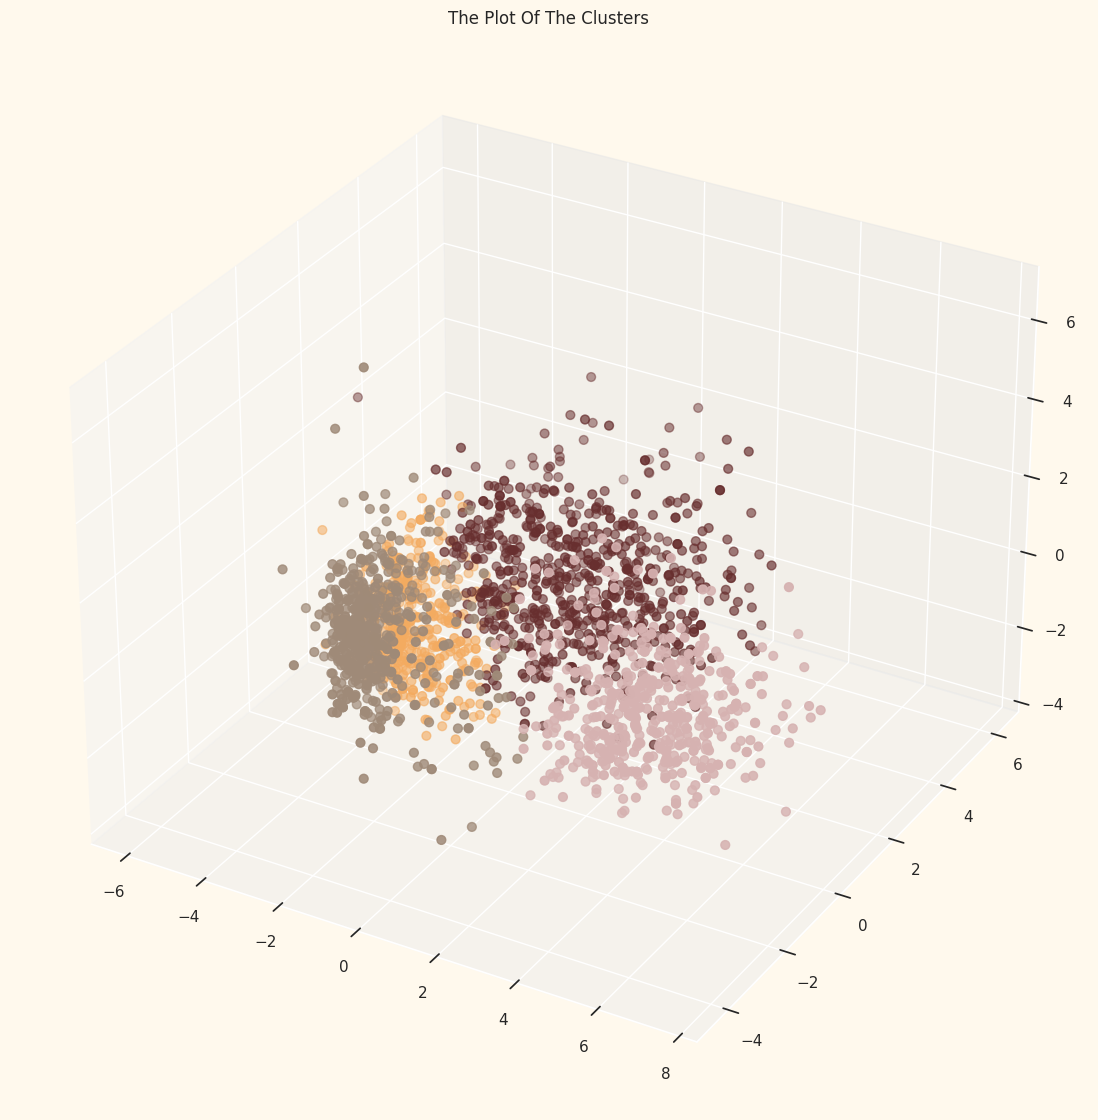

In [28]:
#Plotting the clusters
fig = plt.figure(figsize=(16,14))
ax = plt.subplot(111, projection='3d', label="bla")

ax.scatter(x, y, z, s=40, c=PCA_ds["Clusters"], marker='o', cmap = cmap )
ax.set_title("The Plot Of The Clusters")

plt.show()

# Evaluating Models;

Since this is an unsupervised clustering. We do not have a tagged feature to evaluate or score our model. The purpose of this section is to study the patterns in the clusters formed and determine the nature of the clusters' patterns.

For that, we will be having a look at the data in light of clusters via exploratory data analysis and drawing conclusions.

Firstly, let us have a look at the group distribution of clustring

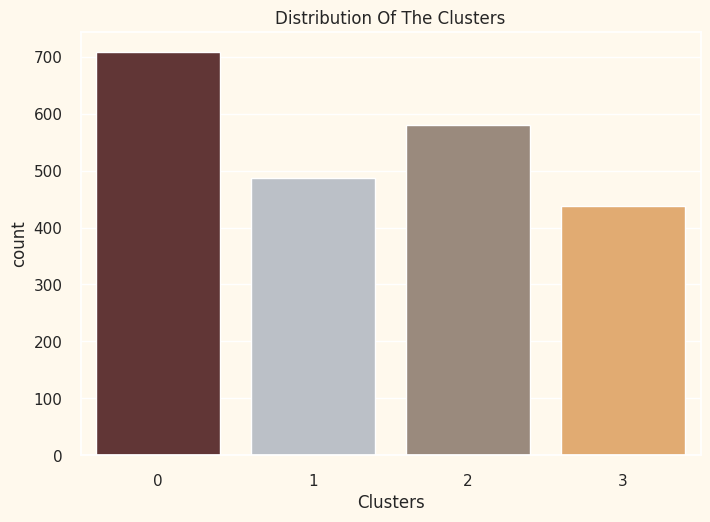

In [29]:
#Plotting countplot of clusters
pal = ["#682F2F","#B9C0C9", "#9F8A78","#F3AB60"]
pl = sns.countplot(x=df["Clusters"], palette= pal)
pl.set_title("Distribution Of The Clusters")
plt.show()

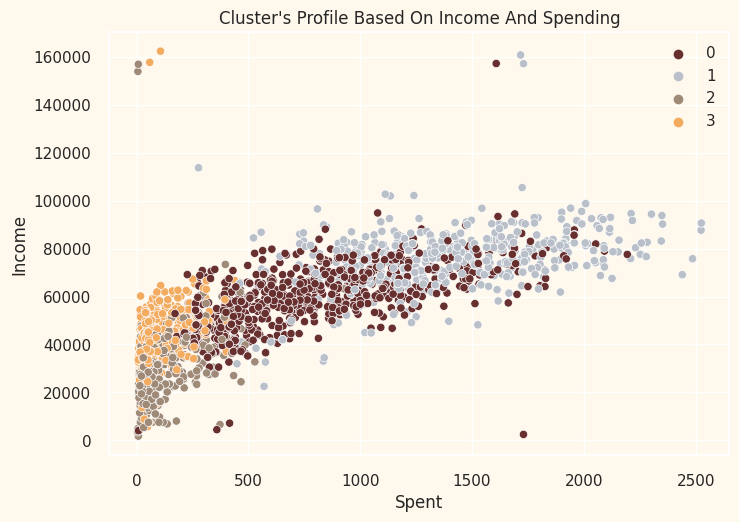

In [30]:
pl = sns.scatterplot(data = df,x=df["Spent"], y=df["Income"],hue=df["Clusters"], palette= pal)
pl.set_title("Cluster's Profile Based On Income And Spending")
plt.legend()
plt.show()

**Relevant Prototype ML Project Deploments;**

-> https://www.youtube.com/watch?v=fx-l-HEUDVE

->https://towardsdatascience.com/how-to-deploy-machine-learning-models-601f8c13ff45

In [31]:
#